# **Mall Customer Segmentation**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy import stats

# Context

You are owing a supermarket mall and through membership cards , you have some  data about your customers like Customer ID, age, gender, annual income and spending score.
Spending Score is something you assign to the customer based on your defined parameters like customer behavior and purchasing data.


# Problem Statement

Segment the customers based on the data and form marketing strategies.

# Loading dataset

In [3]:
df = pd.read_csv('/content/Mall_Customers.csv')
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [4]:
df.shape

(200, 5)

# Exploratory Data Analysis

In [5]:
# drop customerID column
df = df.drop(['CustomerID'], axis = 1)
df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


In [6]:
# check for missing values
df.isnull().sum()

Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [7]:
# check for duplicate records
df[df.duplicated()].shape[0]

0

There are no missing values or duplicates

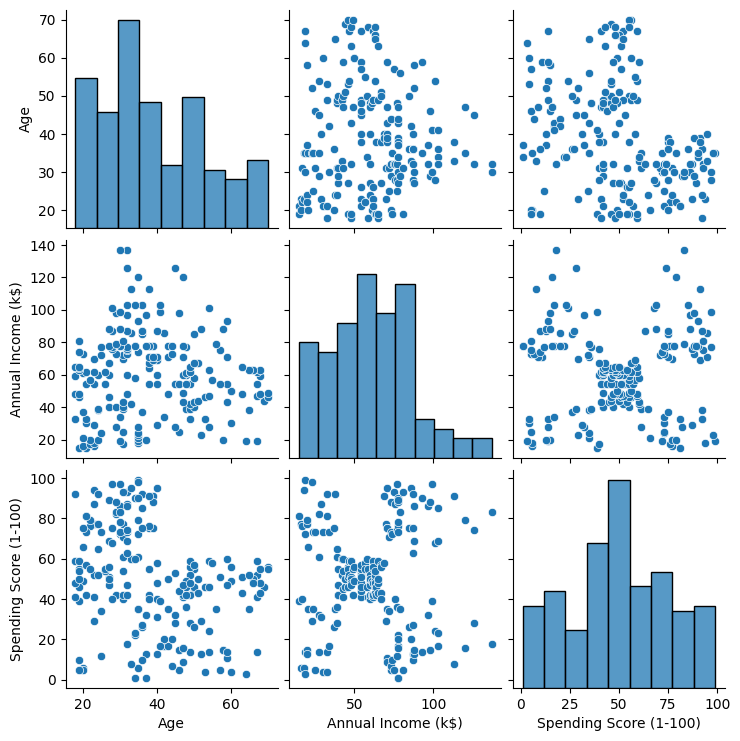

In [15]:
sns.pairplot(df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']])

In [ ]:
df.describe()

,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


The means and std are not quite on the same scale. Lets use StandardScaler to normalize each feature.

In [9]:
col_names = ['Annual Income (k$)', 'Age', 'Spending Score (1-100)']
features = df[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
df_scaled = pd.DataFrame(features, columns = col_names)
df_scaled.head()

,Annual Income (k$),Age,Spending Score (1-100)
0,-1.738999,-1.424569,-0.434801
1,-1.738999,-1.281035,1.195704
2,-1.700830,-1.352802,-1.715913
3,-1.700830,-1.137502,1.040418
4,-1.662660,-0.563369,-0.395980


Since Gender is a categorical feature, it needs to be encoded

In [10]:
gender = df['Gender']
newdf = df_scaled.join(gender)

newdf = pd.get_dummies(newdf, prefix=None, prefix_sep='_', dummy_na=False, columns=None, sparse=False, drop_first=False, dtype=None)
newdf.head()

,Annual Income (k$),Age,Spending Score (1-100),Gender_Female,Gender_Male
0,-1.738999,-1.424569,-0.434801,0,1
1,-1.738999,-1.281035,1.195704,0,1
2,-1.700830,-1.352802,-1.715913,1,0
3,-1.700830,-1.137502,1.040418,1,0
4,-1.662660,-0.563369,-0.395980,1,0


In [ ]:
# drop the redundant column
newdf = newdf.drop(['Gender_Female'],axis=1)


Text(0, 0.5, 'Inertia')

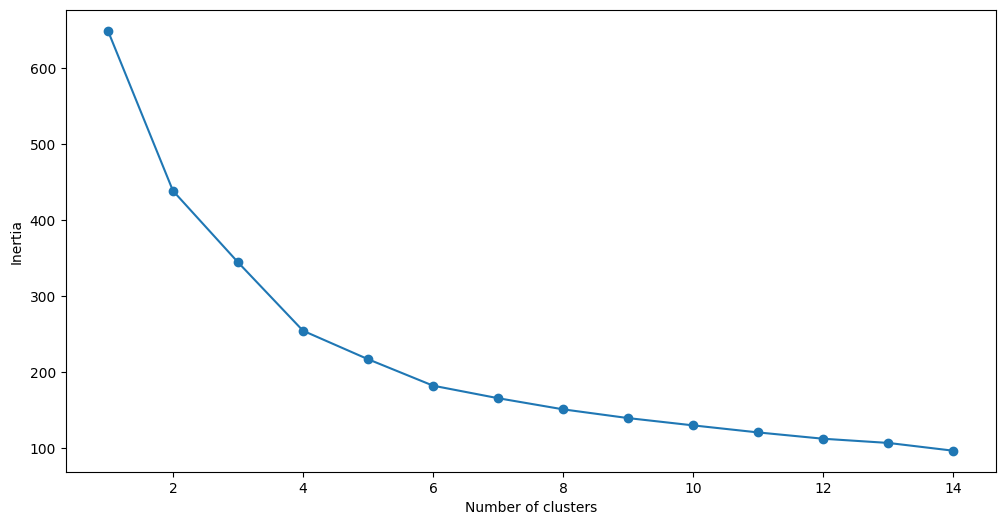

In [12]:
# run KMeans for different values of K and compare the inertia
SSE = []

for k in range(1,15):
    kmeans = KMeans(n_clusters = k, init = 'k-means++', n_init = 10)
    kmeans.fit(newdf)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them

frame = pd.DataFrame({'Cluster':range(1,15), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

Based on the elbow region, the optimal number of clusters could be in the range 4-6. The exact point is not clear. Let's use Silhouette score to check the best approach.

## Comparing KMeans, Hierarchial Clustering and GMMs using Silhouette Score

In [13]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_samples


def get_silhouette_scores(df_to_test):

    avg_silhouette_scores = []

    start_k = 2
    end_k = 15


    for k in range(start_k, end_k+1):

        # Run the KMeans algorithm
        km = KMeans(n_clusters=k, init = 'k-means++', n_init = 10)
        km_labels = km.fit_predict(df_to_test)

        # Run the Hierachical clustering algorithm
        hc = AgglomerativeClustering(n_clusters=k, metric='euclidean', linkage='ward').fit(df_to_test)
        hc_labels = hc.labels_

        # Run the GMMs algorithm
        gm = GaussianMixture(covariance_type="spherical", n_components=k, random_state=0).fit(df_to_test)
        gm_labels = GaussianMixture(n_components=k, random_state=0).fit_predict(df_to_test)

        # calculate average silhouette scores
        km_silhouette_vals = silhouette_samples(df_to_test, km_labels)
        hc_silhouette_vals = silhouette_samples(df_to_test, hc_labels)
        gm_silhouette_vals = silhouette_samples(df_to_test, gm_labels)
        km_avg_score = np.mean(km_silhouette_vals)
        hc_avg_score = np.mean(hc_silhouette_vals)
        gm_avg_score = np.mean(gm_silhouette_vals)
        avg_silhouette_scores.append([km_avg_score, hc_avg_score, gm_avg_score])

    df_avg_silhouette_scores = pd.DataFrame(avg_silhouette_scores, columns = ['KM', 'HC', "GMMs"])
    df_avg_silhouette_scores["k"] = range(start_k, end_k+1)
    print(df_avg_silhouette_scores)

    # plot male and female left-handedness rates vs. age
    fig, ax = plt.subplots() # create figure and axis objects
    fig.set_size_inches(14, 7)
    ax.set_title('Average Silhouette scores for KMeans, Hierachical Clustering, and GMMs in different Ks')
    ax.plot('k', 'KM', data=df_avg_silhouette_scores)
    ax.plot('k', 'HC', data=df_avg_silhouette_scores)
    ax.plot('k', 'GMMs', data=df_avg_silhouette_scores)
    ax.legend(['KMeans',"Hierachical clustering", "GMMS"], title="Clustering Methods") # add a legend
    ax.set_xlabel('K')
    ax.set_ylabel("Average Silhouette Score");

          KM        HC      GMMs   k
0   0.303198  0.292304  0.295462   2
1   0.314280  0.309725  0.300662   3
2   0.350270  0.329905  0.226410   4
3   0.349771  0.347756  0.346576   5
4   0.356486  0.350444  0.311438   6
5   0.332887  0.315405  0.323207   7
6   0.326713  0.325167 -0.162864   8
7   0.306272  0.323259 -0.123598   9
8   0.316551  0.324601 -0.072620  10
9   0.320859  0.302669 -0.079372  11
10  0.335946  0.303701 -0.043137  12
11  0.329635  0.314999  0.027569  13
12  0.331767  0.317114  0.131752  14
13  0.339690  0.314102  0.212117  15


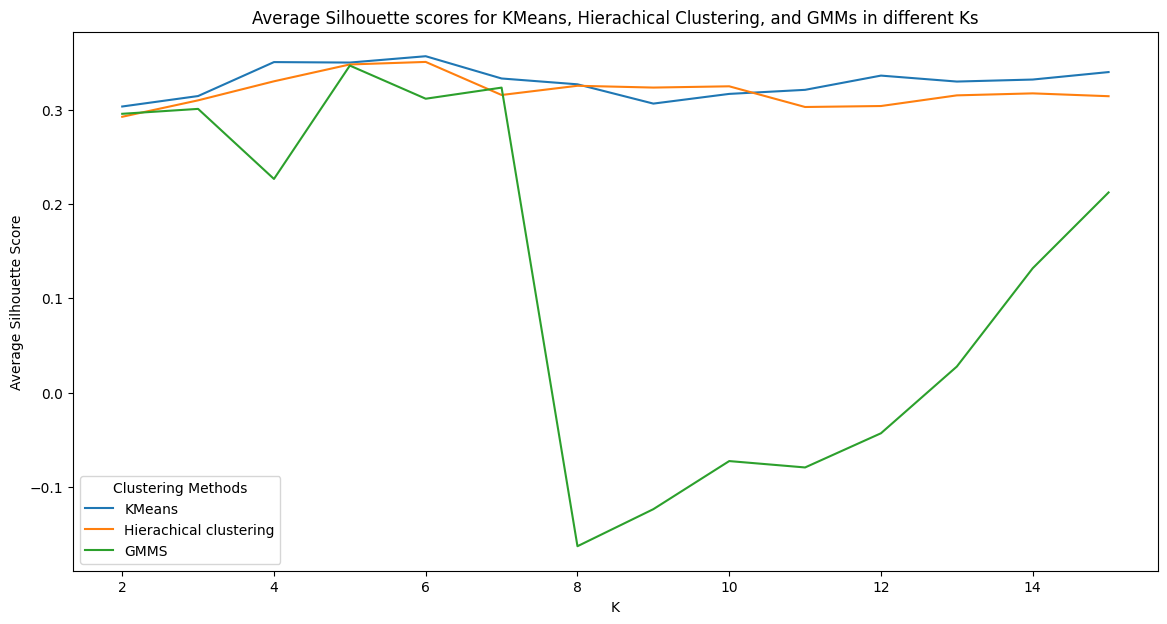

In [14]:
get_silhouette_scores(newdf)

KMeans algorithm with K=6 seems to be performing the best with score of 0.35

Lets see if we can use PCA to reduce dimensionality and see if it gives better Silhouette score

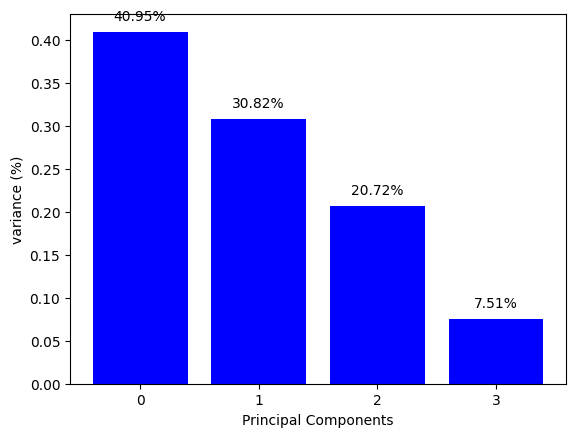

In [19]:
# PCA
pca = PCA(n_components=4)
principalComponents = pca.fit_transform(newdf)

features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='blue')
for i, v in enumerate(pca.explained_variance_ratio_):
    plt.text(i, v+.01, f"{100*v:.2f}%", ha='center', va='bottom')
plt.xlabel('Principal Components')
plt.ylabel('variance (%)')
plt.xticks(features)
plt.show()
PCA_components = pd.DataFrame(principalComponents)

Around 92.5% of the variance is captured by the first 3 components. LEts try to exclude the last one from clustering

In [ ]:
PCA_components.head()

,0,1,2,3
0,-0.600438,-1.737179,1.322247,0.655372
1,-1.649886,-1.789124,0.067789,0.693393
2,0.315381,-1.692772,2.179818,-0.379872
3,-1.477989,-1.781317,0.078518,-0.314797
4,-0.060545,-1.678691,0.688083,-0.370265


          KM        HC      GMMs   k
0   0.335173  0.302742  0.329131   2
1   0.356533  0.304528  0.340779   3
2   0.403327  0.342138  0.377040   4
3   0.411730  0.372685  0.395617   5
4   0.425840  0.360190  0.414524   6
5   0.419106  0.400192  0.400099   7
6   0.412113  0.414315  0.383238   8
7   0.421380  0.392982  0.382968   9
8   0.404032  0.394796  0.376523  10
9   0.411623  0.393839  0.334900  11
10  0.383545  0.389621  0.331658  12
11  0.367796  0.392902  0.304578  13
12  0.370315  0.364769  0.314342  14
13  0.354673  0.346917  0.332802  15


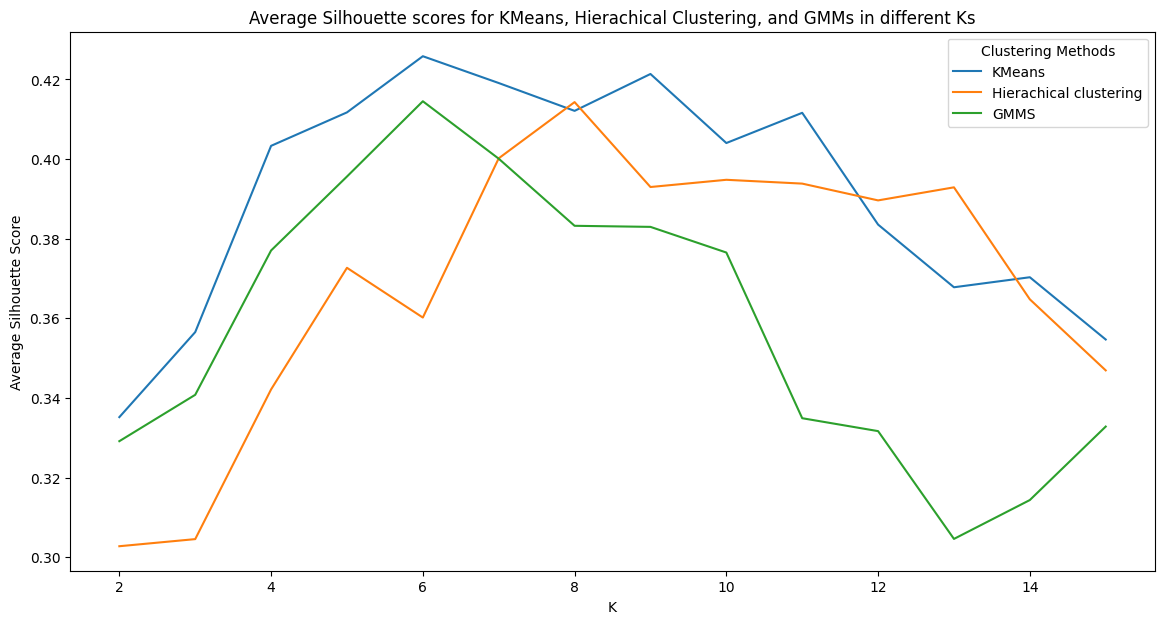

In [ ]:
# excluding the last component and checking the score
get_silhouette_scores(PCA_components.iloc[:,:3])

This gives a better score of 0.42 with K=6 for Kmeans.

## Analyzing the results

Lets use Kmeans with K=6 and assign the cluster labels.

In [20]:
model = KMeans(n_clusters=6, init = 'k-means++', n_init = 10)
df['label'] = model.fit_predict(PCA_components.iloc[:,:3])

Visualizing the Clusters

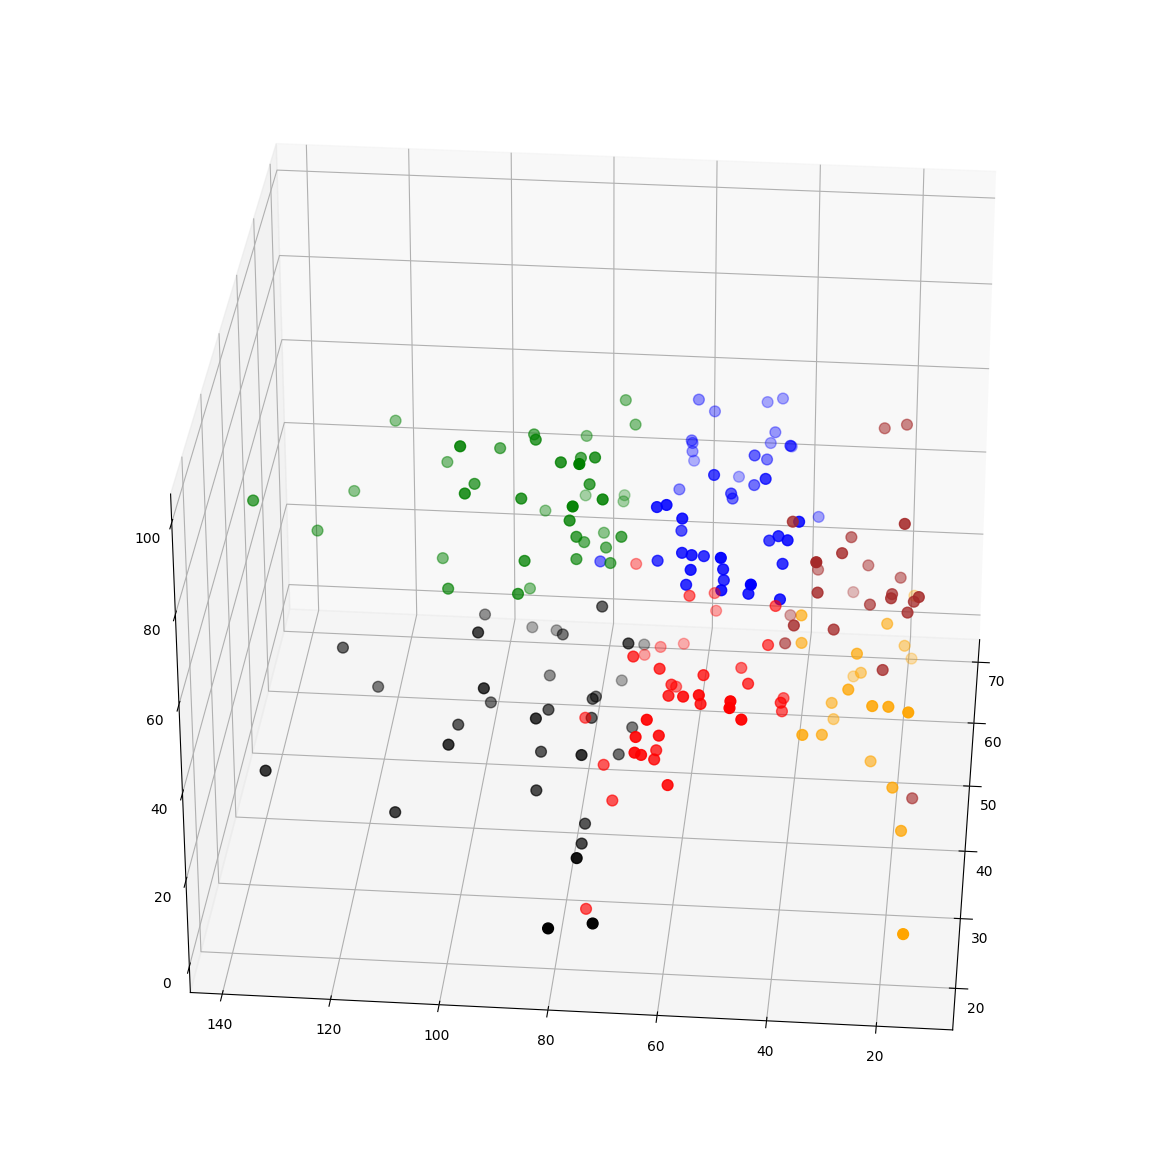

In [32]:
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df.Age[df.label == 0], df["Annual Income (k$)"][df.label == 0], df["Spending Score (1-100)"][df.label == 0], c='blue', s=60)

ax.scatter(df.Age[df.label == 1], df["Annual Income (k$)"][df.label == 1], df["Spending Score (1-100)"][df.label == 1], c='red', s=60)
ax.scatter(df.Age[df.label == 2], df["Annual Income (k$)"][df.label == 2], df["Spending Score (1-100)"][df.label == 2], c='green', s=60)
ax.scatter(df.Age[df.label == 3], df["Annual Income (k$)"][df.label == 3], df["Spending Score (1-100)"][df.label == 3], c='orange', s=60)

ax.scatter(df.Age[df.label == 4], df["Annual Income (k$)"][df.label == 4], df["Spending Score (1-100)"][df.label == 4], c='brown', s=60)

ax.scatter(df.Age[df.label == 5], df["Annual Income (k$)"][df.label == 5], df["Spending Score (1-100)"][df.label == 5], c='black', s=60)

ax.view_init(30, 185)
plt.show()

In [ ]:
df['is_male'] = (df['Gender']=='Male').astype('int')
df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100),cluster_label,is_male
0,Male,19,15,39,4,1
1,Male,21,15,81,4,1
2,Female,20,16,6,2,0
3,Female,23,16,77,4,0
4,Female,31,17,40,2,0


Getting the aggregated cluster-wise features

In [ ]:
results = df.groupby('cluster_label')[['Age', 'Spending Score (1-100)']].mean()
results['Median Annual Income(k$)'] = df.groupby("cluster_label")[['Annual Income (k$)']].median()
results['Male Percentage'] = df.groupby('cluster_label')['is_male'].mean()
results['Female Percentage'] = 1-results['Male Percentage']
results.rename(columns ={'Age': 'Avg Age', 'Spending Score (1-100)': 'Avg Spending Score'}, inplace =True)
results.head(10)

,Avg Age,Avg Spending Score,Median Annual Income(k$),Male Percentage,Female Percentage
cluster_label,,,,,
0,41.264706,16.764706,85.5,0.588235,0.411765
1,32.692308,82.128205,79.0,0.461538,0.538462
2,45.523810,19.380952,25.0,0.380952,0.619048
3,27.000000,49.131579,59.5,0.342105,0.657895
4,25.000000,77.608696,24.0,0.434783,0.565217
5,56.333333,49.066667,54.0,0.422222,0.577778


In [ ]:
results.sort_values(by='Avg Spending Score')

,Avg Age,Avg Spending Score,Median Annual Income(k$),Male Percentage,Female Percentage
cluster_label,,,,,
0,41.264706,16.764706,85.5,0.588235,0.411765
2,45.523810,19.380952,25.0,0.380952,0.619048
5,56.333333,49.066667,54.0,0.422222,0.577778
3,27.000000,49.131579,59.5,0.342105,0.657895
4,25.000000,77.608696,24.0,0.434783,0.565217
1,32.692308,82.128205,79.0,0.461538,0.538462


## Creating Customer Persona around the clusters




*   Group 0: High Income, Low Spending, Middle Age (The Middle Aged Savers)
*   Group 1: High Income, High Spending , Young Age (The Young High Rollers)
*   Group 2: Low Income, Low Spending , Middle Age (The Middle Aged Thriftsters)
*   Group 3: Mid Income, Mid Spending , Young Age (The Millennial Budgeters)
*   Group 4: Low Income, High Spending , Young Age (The Young Splurgers)
*   Group 5: Mid Income, Mid Spending , Old Age (The Balanced Boomers)



## Marketing Strategies

**Group 0: *The Middle Aged Savers***

This group consists of High Income, Low Spending, Middle Age customers. Even though they have high income, they spend less at this mall. There could be two main reasons. Either they shop at other stores/online or they just don't like to spend money at the mall.

Recommendations:
1. Promos/Offers/Discounts for new customers to get them to shop here.
2. Showcase High-End or Luxurious Products and offer personalized discounts.
3. Exclusive Loyalty programs that incentivize repeat spending.
4. Get the word out to them about general amenities like wifi, seating areas and healthy food joints at the mall.

**Group 1: *The Young High Rollers***

This group consists of High Income, High Spending, Young Age customers. In other words, they are rich, have no problem with spending and they have a potential to earn more and more given they are young. So the idea would be to keep them shopping with us.

Recommendations:
1. Loyalty programs
2. Showcase trendy high-end products to them. They mostly want to stay upto date with the latest trends in pop culture.
3. Give referral discounts and get them to bring more of their rich friends to shop with us.

**Group 2: *The Middle Aged Thriftsters***

This group consists of Low Income, Low Spending, Middle Age customers. The goal would be to focus on savings and retain them as customers so that whenever they shop, they shop at our mall.

Recommendations:
1. Give discounts on essential items.
2. Give immediate rewards like cashback.
3. Include budget friendly dining options at the mall.
4. Discounts on toys, childrens' clothes during holidays.


**Group 3: *The Millennial Budgeters***

This group consists of Mid Income, Mid Spending, Young Age customers. Since they are young, they can potentially become high income earners in the future and they may increase their spending accordingly as well. So, the goal is to retain them as customers for a long time.

Recommendations:
1. Loyalty programs


**Group 4: *The Young Splurgers***

This group consists of Low Income, High Spending, young Age customers. Even with low income, they are spending at our mall. The goal is to retain them.

Recommendations:
1. Showcase affordable luxury brands and trending fashion items.
2. Rewards program to encourage them to continue spending.


**Group 5: *The Balanced Boomers***

This group consists of mid Income, mid Spending, old Age customers. Based on this information, they can be assumed to not change their shopping practices. The key would be to retain them by giving them a hassle-free amd comfortable experience so that they stay with our mall.

Recommendations:
1. Loyalty programs
2. Highlight comfort and accessibility